In [40]:
import functions

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib

device = 'charge_qubit' # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

device_module = importlib.import_module('parameters.' + device)
globals().update(vars(device_module)) # import parameters of the device

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [41]:
############################# Set parameters ##############################
if device == 'charge_qubit':
    wlist = np.linspace(0,2,101,endpoint=True)
    Alist = np.array([0.05,0.5])

elif device == 'flopping_spin':
    wlist = np.linspace(0,3*wq,151,endpoint=True)
    Alist = np.array([0.2*wq, 0.3*wq])
    
elif device == 'transmon':
    wlist = np.linspace(0,2*wq,101,endpoint=True)
    Alist = np.array([0.052*wq, 0.09*wq])

elif device == 'fluxonium':
    wlist = np.linspace(0,3*wq,101,endpoint=True)
    Alist = np.array([0.6*wq, 1.2*wq])

else:
    print('select a valid device')
    sys.exit()

tlist = np.linspace(0,.2/kappa,num=3)

ground, excited = 0, 1

############################# Set compensation True/False ##############################
compensation = False

############################## Search for optimal dispersive readout ###############################
dd2_real_disp = functions.get_derivatives(N_rep,0.01*wq,H_sys,drive_op,wlist,n_states,num_A)[2]

chi1_disp = g**2*dd2_real_disp[:,2,excited]
chi0_disp = g**2*dd2_real_disp[:,2,ground]

chi_disp = chi1_disp-chi0_disp
chi_disp_sum = chi1_disp+chi0_disp

index_wr_low = np.argwhere(wlist > 0.3*wq)[0][0] \
    + (np.abs(np.abs(chi_disp[np.argwhere(wlist > 0.3*wq)[0][0]:np.argwhere(wlist >= wq)[0][0]])-kappa/2)).argmin() # find optimal dispersive readout low freq.

index_wr_high = np.argwhere(wlist >= wq)[0][0] \
    + (np.abs(np.abs(chi_disp[np.argwhere(wlist >= wq)[0][0]:-1])-kappa/2)).argmin() # find optimal dispersive readout high freq.


print(r'$\chi_{\text{disp}}/\kappa/2$='+str(chi_disp[index_wr_low]/(kappa/2))+', '+str(chi_disp[index_wr_high]/(kappa/2))\
      +r' obtained at $\omega_r/\omega_q$='+str(wlist[index_wr_low]/wq)+' ,'+str(wlist[index_wr_high]/wq))

$\chi_{\text{disp}}/\kappa/2$=1.0525697215014547, -0.952330324649996 obtained at $\omega_r/\omega_q$=0.9 ,1.1


In [42]:
res_num = np.zeros((len(Alist),len(wlist)), dtype=object)
res_an = np.zeros((len(Alist),len(wlist)), dtype=object)
res_num_disp = np.zeros((len(Alist),len(wlist)), dtype=object)

for i, A_q in enumerate(Alist):    

    A_list, dd_real, dd2_real = functions.get_derivatives(N_rep,A_q,H_sys,drive_op,wlist,n_states,num_A)

    index_A = np.abs(A_list-A_q).argmin()

    print('derivatives of the spectrum computed in A_q='+str(A_list[index_A]))

    for j, w_r in enumerate(wlist):

        if np.abs(w_r-wq)<10**(-3):
            gamma = 10000
        else:
            gamma = kappa*(g/(wq-w_r))**2 # Purcell

        g0 = g*(dd_real[j,index_A,0])
        g1 = g*(dd_real[j,index_A,1])
        
        chi0 = g**2*(dd2_real[j,index_A,0]+1/A_q*dd_real[j,index_A,0])        
        chi1 = g**2*(dd2_real[j,index_A,1]+1/A_q*dd_real[j,index_A,1])

        g_parallel = 1/2*(g1-g0)
        chi = 1/2*(chi1-chi0)

        g_sum = 1/2*(g1+g0)
        chi_sum = 1/2*(chi1+chi0)
    
        if(compensation):
            w_d = w_r+chi_sum # shifted resonator frequency
            A_d = -2*g_sum # compensation tone
        else:
            w_d = w_r
            A_d = 0

        res_a_num = [[],[]]
        res_a_an = [[],[]]
        res_a_disp = [[],[]]

        for idx, qubit_state in enumerate([ground,excited]):

            numerical_result = functions.real_time_dynamics(H_sys,A_q,A_d,w_r,w_d,0,g,drive_op,n_states,kappa,qubit_state,tlist,N_fock)
            res_a_num[idx].append(numerical_result)

            z0 = functions.get_z0(N_rep,A_q,num_A,H_sys,drive_op,w_d,qubit_state,ground,excited,n_states)
            
            analytical_result = functions.analytical_time_dynamics(z0,w_r,w_d,A_d,qubit_state,g_parallel,g_sum,chi,chi_sum,kappa,gamma,tlist)
            res_a_an[idx].append(analytical_result)
                    
            if w_r < wq:
                temp_chi = chi_disp[index_wr_low]
                w_r_disp = wlist[index_wr_low]
            if w_r >= wq:
                temp_chi = chi_disp[index_wr_high]
                w_r_disp = wlist[index_wr_high]

            A_r = g_parallel*kappa/temp_chi*(temp_chi**2+kappa**2/4)/(chi**2+kappa**2/4)
            
            if(compensation):
                w_d_disp = w_r_disp+chi_disp_sum # shifted resonator frequency
            else:
                w_d_disp = w_r_disp

            numerical_dispersive_result = functions.real_time_dynamics(H_sys,0,A_r,w_r,w_d_disp,phi,g,drive_op,n_states,kappa,qubit_state,tlist,N_fock)
            res_a_disp[idx].append(numerical_dispersive_result)

        res_num[i,j] = functions.generate_SNR_list(res_a_num,kappa,tlist)[-1]
        res_an[i,j] = functions.generate_SNR_list(res_a_an,kappa,tlist)[-1]
        res_num_disp[i,j] = functions.generate_SNR_list(res_a_disp,kappa,tlist)[-1]

derivatives of the spectrum computed in A_q=0.049358974358974364


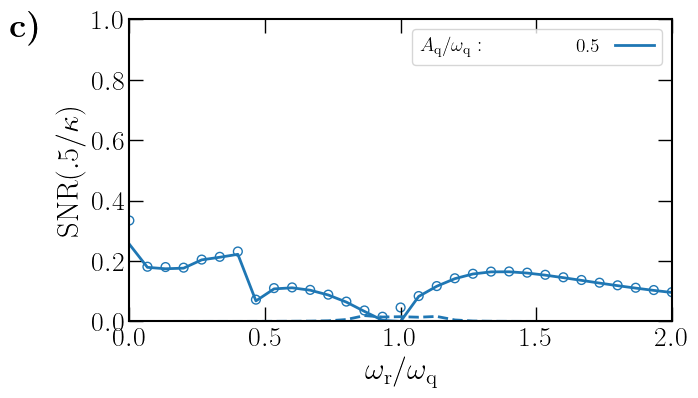

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(7,4), dpi=100)

import matplotlib.colors as mcolors
cmap = mpl.colormaps["tab10"]  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

for idx,A in enumerate(Alist):
    ax.plot(wlist/wq, np.real(res_an[idx,:]), label=str(np.round(A/wq,2)), color=colors[idx], lw=2)   
    ax.plot(wlist/wq, np.real(res_num_disp[idx,:]), color=colors[idx], lw=2, ls='--')    
    ax.scatter(wlist/wq, np.real(res_num[idx,:]), marker='o', color=colors[idx], facecolors='none', s=40)    

ax.set_ylim([0,1])

ax.legend(loc='upper right')

ax.xaxis.set_tick_params(direction="in", which='both')
ax.yaxis.set_tick_params(direction="in", which='both')
ax.set_xlabel(r'$\omega_{\text{r}}/\omega_{\text{q}}$')

ax.set_ylabel(r'$\text{SNR}(.5/\kappa)$')
ax.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True,
                  labelbottom=True, labelright=False, labeltop=False, which='both')

h, l = ax.get_legend_handles_labels() # Extracting handles and labels
ph = [plt.plot([],marker="", ls="")[0]] # Canvas
handles = ph + h
labels = [r'$A_{\text{q}}/\omega_{\text{q}}:$'] + l  # Merging labels
leg = ax.legend(handles, labels, fontsize="14", ncol=4, markerfirst=False)

In [ ]:
fname = device+'_SNR'

np.savez(fname, g=g, kappa=kappa, wq=wq, Alist=Alist, wlist=wlist, res_an=res_an, res_num_disp=res_num_disp, res_num=res_num,\
        index_wr_low=index_wr_low, index_wr_high=index_wr_high)